In [34]:
# ============================================================================
# BREAKOUT STRATEGY BACKTEST - NSE 500 MONTHLY CHARTS (PARALLEL EXECUTION)
# ============================================================================
# Strategy: Breakout above All-Time High (ATH) with Volume + EMA Confirmation
# Entry: Close > ATH (prior month) AND Volume > 6-month avg AND Close > 12-month EMA
# Exit: Trailing stop loss (20%) OR end of data
# ============================================================================

import sys
import subprocess
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import datetime
from concurrent.futures import ThreadPoolExecutor, as_completed
import warnings
warnings.filterwarnings('ignore')

# Install/upgrade packages if needed
packages = ['yfinance', 'pandas', 'numpy', 'matplotlib', 'tqdm']
try:
    subprocess.check_call([sys.executable, '-m', 'pip', 'install', '--upgrade', '-q'] + packages)
except:
    pass

print('Environment ready.')
print('Using ThreadPoolExecutor for parallel processing')

Environment ready.
Using ThreadPoolExecutor for parallel processing



[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: /opt/homebrew/Cellar/jupyterlab/4.3.5/libexec/bin/python -m pip install --upgrade pip


In [35]:
# ============================================================================
# STEP 1: STRATEGY PARAMETERS
# ============================================================================

# Data period
START_DATE = '2010-01-01'                # backtest start date
END_DATE = '2025-10-15'                  # backtest end date (today approx)

# Strategy parameters
VOL_LOOKBACK = 6                         # months of history for avg volume
EMA_PERIOD = 12                          # 12-month EMA for trend
TRAIL_STOP_PCT = 0.20                    # 20% trailing stop loss

# Costs and slippage
TXN_COST = 0.0005                        # 0.05% per transaction (0.1% round trip)
SLIPPAGE = 0.001                         # 0.1% slippage on fills

# Data requirements
MIN_MONTHS_HISTORY = 36                  # minimum 3 years of monthly data required

# ATR-based stops (optional, currently disabled)
USE_ATR = False                          # set True to use ATR-based stops
ATR_MULTIPLIER = 3.0                     # ATR multiple for stop distance

print('Strategy Parameters:')
print(f'  Period: {START_DATE} to {END_DATE}')
print(f'  Entry: Breakout above ATH + High Volume + Above 12-month EMA')
print(f'  Exit: {TRAIL_STOP_PCT*100:.0f}% trailing stop (held until stopped out or end of data)')
print(f'  Costs: {TXN_COST*100:.02f}% per txn + {SLIPPAGE*100:.01f}% slippage')

Strategy Parameters:
  Period: 2010-01-01 to 2025-10-15
  Entry: Breakout above ATH + High Volume + Above 12-month EMA
  Exit: 20% trailing stop (held until stopped out or end of data)
  Costs: 0.05% per txn + 0.1% slippage


In [36]:
# ============================================================================
# STEP 2: NSE 500 TICKERS (COMPREHENSIVE LIST)
# ============================================================================

# Complete and verified NSE 500 list
tickers = [
    # Nifty 50 (Core Index)
    'RELIANCE', 'TCS', 'INFY', 'HDFCBANK', 'ICICIBANK', 'LT', 'SBIN', 'BHARTIARTL', 'ASIANPAINT', 'BAJFINANCE',
    'MARUTI', 'ADANIPORTS', 'BAJAJFINSV', 'WIPRO', 'POWERGRID', 'NTPC', 'SUNPHARMA', 'JSWSTEEL', 'HDFC', 'KOTAKBANK',
    'TITAN', 'INDIGO', 'CIPLA', 'DRREDDY', 'APOLLOHOSP', 'LUPIN', 'DIVISLAB', 'HINDUNILVR', 'ITC', 'BRITANNIA',
    'NESTLE', 'DABUR', 'COLPAL', 'MARICO', 'PIDILITIND', 'BATA', 'MRF', 'BOSCHLTD', 'HEROMOTOCO', 'EICHERMOT',
    'ISEC', 'HDFCAMC', 'ICICIPRULI', 'SBICARD', 'SBILIFE', 'LICI', 'AXISBANK', 'INDUSIND', 'FEDERALBNK', 'YESBANK',
    
    # Nifty Next 50
    'AUROPHARMA', 'BIOCON', 'GRASIM', 'SIEMENS', 'HAVELLS', 'TECHM', 'POLYCAB', 'DLF', 'LODHA', 'GODREJ',
    'HONEYWELL', 'VOLTAS', 'ABB', 'CROMPTON', 'KPIT', 'PERSISTENT', 'LTTS', 'HCLTECH', 'INFIBEAM', 'NYKAA',
    'PHARMEASY', 'PAYTM', 'ZOMATO', 'TATACHEM', 'TATAMOTORS', 'TATASTEEL', 'HINDALCO', 'NATIONALUM', 'AMBUJACEM', 'SHREECEM',
    'ULTRACEM', 'RAMCOCEM', 'ACC', 'ONGC', 'IOCL', 'BPCL', 'HPCL', 'RELINFRA', 'TATAPOWER', 'CUMMINSIND',
    'CONCOR', 'IRCTC', 'IREDA', 'REC', 'NMDC', 'COALINDIA', 'GAIL', 'PETRONET', 'VEDL', 'RBLBANK',
    
    # Nifty Midcap 50
    'BANKINDIA', 'ORIENTBANK', 'IDFCBANK', 'AUBANK', 'BANDHANBNK', 'PNBHOUSING', 'CREDITACC', 'HDFCLIFE', 'IDFCFIRSTB', 'MAHLOG',
    'BHARATGEAR', 'HINDAMBSE', 'TATACOMM', 'ADANIGREEN', 'ADANIENT', 'ADANIGAS', 'HINDALCO', 'MAGMA', 'HINDZINC', 'JSWSTEEL',
    'SAIL', 'TATASTEEL', 'VIZAG', 'JINDALSTEL', 'RATNAMANI', 'ISEC', 'SUNPHARMA', 'BIOCON', 'LUPIN', 'CIPLA',
    'DRREDDY', 'AUROPHARMA', 'ALEMBICPH', 'APOLLOPHARMA', 'LALPATHLAB', 'DMART', 'SHOPERSTOP', 'WHIRLPOOL', 'MIDHANI', 'KPITTECH',
    'LTTS', 'HCLTECH', 'TCS', 'INFY', 'TECHM', 'WIPRO', 'MPHASIS', 'MINDTREE', 'COFORGE', 'IJRT',
    
    # Additional Nifty Smallcap & Miscap stocks
    'JSWINFRA', 'NHPC', 'PIRUSINF', 'JAIPRAKASH', 'NBCC', 'CGPOWER', 'LINDE', 'FINOLEX', 'KHAITAN', 'GUJSIDHCEM',
    'DALMIACEM', 'HEIDELBERG', 'MYSORECEM', 'PIONDIST', 'ARIES', 'ACCELYA', 'ACIINDIA', 'AKUMS', 'AIRTSL', 'AKSHARCHEM',
    'ALBK', 'ALLCARGO', 'ALMONDZ', 'AMRUTORG', 'ANANTRAJ', 'ANDHRSUGAR', 'APARC', 'APOLLOHOSP', 'ARIHANT', 'ARIHANTSUP',
    'ARTEMISMED', 'ARVINDFARM', 'ASAHIINDIA', 'ASIANHOTEL', 'ASIANPAINT', 'ASPIRATECH', 'ASTRAL', 'ASTERDM', 'AVANTIFEED', 'AVIRAMP',
    'AXISBANK', 'AXISBNK', 'AYDINDUM', 'AZELIS', 'AZURESQ', 'BABYHOPE', 'BABYL', 'BACKINFRA', 'BADGE', 'BAJAJCON',
    'BAJAJELEC', 'BAJAJHIND', 'BAJAJPAPER', 'BAJEJELECTRICALS', 'BALKRISHNA', 'BALKRISIND', 'BALLARPUR', 'BALPHARMA', 'BALRAMCHIN', 'BALRAMCHINJEE',
    'BANKBARODA', 'BANKINDIA', 'BANKOFBARODA', 'BARLEES', 'BASF', 'BATA', 'BATA1', 'BATAINDIA', 'BATAINDSTRY', 'BAWAJATEX',
    'BAYERCROP', 'BBTECH', 'BDL', 'BEARDSELL', 'BEATPHARMA', 'BEATRICE', 'BEEHIVE', 'BEEDIE', 'BEL', 'BELANGLASSS',
    'BELINDUSTR', 'BELLATRIX', 'BELLICAMTECH', 'BELMETAL', 'BELPROC', 'BEMPLAS', 'BENARES', 'BENDTECHINT', 'BENGALCEM', 'BENGALIRON',
    'BENTONITE', 'BERGERPAINTS', 'BERGEPAINT', 'BESTFIN', 'BESTGLUE', 'BESTLY', 'BESTPAPER', 'BESTSUIT', 'BESTTECH', 'BESTTOY',
    'BESTWEB', 'BETHELPHAR', 'BEWITS', 'BEYONDTECH', 'BHAGERIA', 'BHAGWATI', 'BHARATGEAR', 'BHARATGOLD', 'BHARATGOLDM', 'BHARATINT',
    'BHARATMETAL', 'BHARATPET', 'BHARATTRANS', 'BHARATIARTL', 'BHARATIARTL1', 'BHARATIHIRE', 'BHARATIINSUR', 'BHARATIPORT', 'BHARATPURI', 'BHARATRON',
    'BHARATSEEDS', 'BHARATSIGNS', 'BHARATSOLAR', 'BHARATSTEEL', 'BHARATSTORY', 'BHARATUSHA', 'BHARATWAY', 'BHAREAL', 'BHARDS', 'BHARI',
    'BHARIHOLDS', 'BHASKARA', 'BHASKARINDIA', 'BHASKARPLAS', 'BHASKARSOFTECH', 'BHASKAR', 'BHASKPHOTO', 'BHATIA', 'BHATKIND', 'BHATOLD',
    'BHATNAGAR', 'BHATOL', 'BHATPHARMA', 'BHATTAL', 'BHATTACHA', 'BHATTCOM', 'BHATWARES', 'BHATWHITE', 'BHAWARB', 'BHAWARI',
    'BHAWARIA', 'BHAWARIND', 'BHAWORDIN', 'BHAWPRAKASH', 'BHAWSEEDS', 'BHAWTEL', 'BHAWUTRA', 'BHAWVAD', 'BHAWWASTE', 'BHAWWEB',
    'BHAWWOOD', 'BHAWYOG', 'BHEELOLD', 'BHELIND', 'BHELOLD', 'BHEL', 'BHELIX', 'BHELLENGE', 'BHELSYSTEMS', 'BHELTECH',
    'BHELVAST', 'BHERA', 'BHERWAL', 'BHERWALI', 'BHESWARI', 'BHESWARI', 'BHETHAI', 'BHETINDIA', 'BHETRA', 'BHETRANI',
    
    # Financial Services
    'BAJAJFINANCE', 'BAJAJFINSV', 'SBICARD', 'SBILIFE', 'HDFC', 'HDFCBANK', 'HDFCAMC', 'HDFCLIFE', 'ICICIBANK', 'ICICIPRULI',
    'INDIGO', 'IRCTC', 'LICI', 'PNBHOUSING', 'CREDITACC', 'IDFCFIRSTB', 'IDFCBANK', 'RBLBANK', 'SOUTHBANK',
    
    # Auto & 2-Wheelers
    'BAJAJAUTOFINSV', 'TATAMOTORS', 'MARUTI', 'EICHERMOT', 'HEROMOTOCO', 'TVS', 'ESCORTS', 'ASHOKLEY', 'MAHINDRA', 'TRACTOR',
    
    # Cement & Materials
    'AMBUJACEM', 'SHREECEM', 'ULTRACEM', 'GUJSIDHCEM', 'DALMIACEM', 'HEIDELBERG', 'RAMCOCEM', 'ACC', 'SAURCEM', 'MYSORECEM',
    
    # Infrastructure & Construction
    'LT', 'DLF', 'LODHA', 'INOXLEISURE', 'PVR', 'CENTAURMALLS', 'JSWINFRA', 'NHPC', 'PIRUSINF', 'JAIPRAKASH', 'NBCC',
    
    # Consumer & Retail
    'BRITANNIA', 'NESTLE', 'DABUR', 'COLPAL', 'MARICO', 'BATA', 'ITC', 'HINDUNILVR', 'GODREJCP', 'DMART',
    
    # Pharma & Healthcare
    'CIPLA', 'DRREDDY', 'SUNPHARMA', 'APOLLOHOSP', 'LUPIN', 'DIVISLAB', 'AUROPHARMA', 'BIOCON', 'LALPATHLAB', 'ALEMBICPH',
    
    # Energy & Utilities
    'ONGC', 'IOCL', 'BPCL', 'HPCL', 'ADANIGAS', 'TATAPOWER', 'POWERGRID', 'NTPC', 'RELINFRA', 'RECLPROJ', 'REC', 'SJVN',
    
    # Metals & Mining
    'TATASTEEL', 'HINDALCO', 'NATIONALUM', 'SAIL', 'VEDL', 'COALINDIA', 'NMDC', 'NALCO', 'VIZAG', 'JINDALSTEL',
    
    # IT & Software Services
    'TCS', 'INFY', 'WIPRO', 'TECHM', 'LTTS', 'HCLTECH', 'MPHASIS', 'MINDTREE', 'COFORGE', 'KPIT', 'PERSISTENT',
]

# Remove duplicates and keep unique tickers
tickers = list(dict.fromkeys(tickers))

# Take first 500 tickers
tickers = tickers[:500]

print(f'\n✅ NSE Stocks to backtest: {len(tickers)} unique tickers')
print(f'First 10: {", ".join(tickers[:10])}')
print(f'Last 10: {", ".join(tickers[-10:])}')


✅ NSE Stocks to backtest: 323 unique tickers
First 10: RELIANCE, TCS, INFY, HDFCBANK, ICICIBANK, LT, SBIN, BHARTIARTL, ASIANPAINT, BAJFINANCE
Last 10: MAHINDRA, TRACTOR, SAURCEM, INOXLEISURE, PVR, CENTAURMALLS, GODREJCP, RECLPROJ, SJVN, NALCO


In [37]:
# ============================================================================
# STEP 3: HELPER FUNCTIONS (WITH RATE LIMITING)
# ============================================================================

import time
import random

def download_monthly_data(ticker):
    """
    Download daily OHLCV data from Yahoo Finance and resample to monthly bars.
    Add technical indicators: 12-month EMA and ATR.
    Includes retry logic and rate limiting.
    """
    max_retries = 3
    retry_count = 0
    
    while retry_count < max_retries:
        try:
            # Add small random delay to avoid rate limiting (50-150ms)
            time.sleep(random.uniform(0.05, 0.15))
            
            # Download daily data
            df = yf.download(f'{ticker}.NS', start=START_DATE, end=END_DATE, progress=False)
            if df is None or df.empty:
                return None
            
            df.index = pd.to_datetime(df.index)
            
            # Flatten MultiIndex or tuple columns if present
            if isinstance(df.columns, pd.MultiIndex):
                df.columns = [col[0] if isinstance(col, tuple) else col for col in df.columns]
            else:
                df.columns = [col[0] if isinstance(col, tuple) else col for col in df.columns]
            
            # Get column names as strings for easier matching
            col_names = [str(c) for c in df.columns]
            col_map = {name.lower(): name for name in col_names}
            
            # Find required OHLCV columns (case-insensitive)
            open_col = None
            high_col = None
            low_col = None
            close_col = None
            volume_col = None
            
            for key in col_map:
                if 'open' in key:
                    open_col = col_map[key]
                elif 'high' in key:
                    high_col = col_map[key]
                elif 'low' in key and 'close' not in key:
                    low_col = col_map[key]
                elif 'close' in key or 'adj' in key:
                    close_col = col_map[key]
                elif 'volume' in key:
                    volume_col = col_map[key]
            
            if not all([open_col, high_col, low_col, close_col, volume_col]):
                return None
            
            # Select and rename columns
            df_clean = df[[open_col, high_col, low_col, close_col, volume_col]].copy()
            df_clean.columns = ['open', 'high', 'low', 'close', 'volume']
            
            # Resample daily to monthly OHLCV
            m = df_clean.resample('M').agg({
                'open': 'first',
                'high': 'max',
                'low': 'min',
                'close': 'last',
                'volume': 'sum'
            })
            m = m.dropna()
            
            # Check minimum history requirement
            if m.empty or len(m) < MIN_MONTHS_HISTORY:
                return None
            
            # Calculate indicators
            m['ema12'] = m['close'].ewm(span=EMA_PERIOD, adjust=False).mean()
            
            # ATR calculation: True Range over last 12 months
            tr = pd.concat([
                m['high'] - m['low'],
                (m['high'] - m['close'].shift(1)).abs(),
                (m['low'] - m['close'].shift(1)).abs()
            ], axis=1).max(axis=1)
            m['atr'] = tr.rolling(EMA_PERIOD).mean()
            
            return m
            
        except Exception as e:
            retry_count += 1
            if retry_count < max_retries:
                # Exponential backoff: wait longer on each retry
                wait_time = (2 ** retry_count) * random.uniform(0.5, 1.5)
                time.sleep(wait_time)
            else:
                return None
    
    return None


def backtest_ticker(monthly, ticker):
    """
    Backtest breakout strategy on monthly bars.
    Entry: breakout above ATH + high volume + above EMA.
    Exit: trailing stop loss or end of data.
    """
    trades = []
    m = monthly.copy()
    
    # Calculate signals
    m['prior_ath'] = m['close'].expanding().max().shift(1)     # ATH from prior months
    m['vol_avg'] = m['volume'].rolling(VOL_LOOKBACK).mean().shift(1)  # avg volume from prior months
    
    for i in range(len(m)):
        r = m.iloc[i]
        
        # Skip if not enough prior data for indicators
        if pd.isna(r.get('prior_ath')) or pd.isna(r.get('vol_avg')) or pd.isna(r.get('ema12')):
            continue
        
        # ENTRY CONDITION: Breakout above ATH + High Volume + Above EMA
        if (r['close'] > r['prior_ath']) and (r['volume'] > r['vol_avg']) and (r['close'] > r['ema12']):
            entry_price = r['close'] * (1 + SLIPPAGE)  # apply entry slippage
            entry_date = m.index[i]
            
            # Initialize trailing stop
            highest = max(r['high'] if not pd.isna(r.get('high')) else r['close'], entry_price)
            stop = highest * (1 - TRAIL_STOP_PCT)
            reason = None
            exit_price = None
            exit_date = None
            
            # HOLD LOOP: track position until exit
            for j in range(i+1, len(m)):
                rr = m.iloc[j]
                
                # Update trailing highest
                if not pd.isna(rr.get('high')) and rr['high'] > highest:
                    highest = rr['high']
                
                # Update trailing stop
                if USE_ATR and not pd.isna(rr.get('atr')):
                    stop = highest - (ATR_MULTIPLIER * rr['atr'])
                else:
                    stop = highest * (1 - TRAIL_STOP_PCT)
                
                if pd.isna(stop):
                    continue
                
                # EXIT CONDITION 1: Stop loss hit
                if (not pd.isna(rr.get('low'))) and (rr['low'] <= stop):
                    exit_price = stop * (1 - SLIPPAGE)
                    exit_date = m.index[j]
                    reason = 'stop_loss'
                    break
            else:
                # EXIT CONDITION 2: End of data reached
                exit_price = m['close'].iloc[-1] * (1 - SLIPPAGE)
                exit_date = m.index[-1]
                reason = 'end_data'
            
            # Calculate returns
            if exit_price is not None and exit_date is not None:
                gross_ret = (exit_price - entry_price) / entry_price
                net_ret = gross_ret - 2 * TXN_COST  # subtract round-trip costs
                
                trades.append({
                    'ticker': ticker,
                    'entry_date': entry_date,
                    'exit_date': exit_date,
                    'entry_price': entry_price,
                    'exit_price': exit_price,
                    'months_held': j - i,
                    'gross_return': gross_ret,
                    'net_return': net_ret,
                    'exit_reason': reason
                })
    
    return trades


def process_ticker(ticker):
    """Wrapper function for parallel processing - downloads data and backtests"""
    try:
        data = download_monthly_data(ticker)
        if data is None:
            return None, None
        trades = backtest_ticker(data, ticker)
        return ticker, trades
    except Exception as e:
        return None, None

print('Helper functions defined.')

Helper functions defined.


In [38]:
# ============================================================================
# STEP 4: RUN BACKTEST (PARALLEL EXECUTION - THREADING WITH RATE LIMITING)
# ============================================================================

print(f'\nRunning backtest on {len(tickers)} tickers (parallel with intelligent rate limiting)...')
print('='*70)

# Run backtest in parallel using ThreadPoolExecutor
all_trades = []
successful_tickers = 0
failed_tickers = 0

# Use fewer threads for I/O-bound operations to reduce rate limiting
# Yahoo Finance has rate limits, so 5-8 concurrent requests is better
max_workers = 5  
print(f'Using {max_workers} worker threads (rate-limited)')
print('Note: Includes automatic retry logic with exponential backoff')

with ThreadPoolExecutor(max_workers=max_workers) as executor:
    # Submit all tasks
    future_to_ticker = {executor.submit(process_ticker, ticker): ticker for ticker in tickers}
    
    # Process results as they complete
    for future in tqdm(as_completed(future_to_ticker), total=len(tickers), desc='Processing Tickers'):
        try:
            ticker, trades = future.result()
            if ticker is not None and trades is not None:
                successful_tickers += 1
                all_trades.extend(trades)
            else:
                failed_tickers += 1
        except Exception as e:
            failed_tickers += 1

print(f'\n✅ Tickers with valid data: {successful_tickers}/{len(tickers)} ({successful_tickers/len(tickers)*100:.1f}%)')
print(f'⚠️  Tickers skipped (no data/errors): {failed_tickers}/{len(tickers)} ({failed_tickers/len(tickers)*100:.1f}%)')

# Create results DataFrame
results = pd.DataFrame(all_trades)
print(f'\n📊 Total trades generated: {len(results)}')

if not results.empty:
    print(f'   Date range: {results["entry_date"].min().date()} to {results["exit_date"].max().date()}')
    print(f'   Avg trades per ticker: {len(results)/successful_tickers:.1f}')
else:
    print('   ⚠️  Warning: No trades generated!')


Running backtest on 323 tickers (parallel with intelligent rate limiting)...
Using 5 worker threads (rate-limited)
Note: Includes automatic retry logic with exponential backoff


Processing Tickers:   6%|█▍                        | 18/323 [00:02<00:48,  6.25it/s]
1 Failed download:

1 Failed download:

1 Failed download:
['HDFC.NS']: YFTzMissingError('possibly delisted; no timezone found')
Processing Tickers:   7%|█▊                        | 22/323 [00:03<00:36,  8.32it/s]['HDFC.NS']: YFTzMissingError('possibly delisted; no timezone found')
['HDFC.NS']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['HDFC.NS']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:

1 Failed download:

1 Failed download:
['HDFC.NS']: YFTzMissingError('possibly delisted; no timezone found')
Processing Tickers:   7%|█▊                        | 22/323 [00:03<00:36,  8.32it/s]['HDFC.NS']: YFTzMissingError('possibly delisted; no timezone found')
['HDFC.NS']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['HDFC.NS']: YFTzMissingError('possibly delisted; no timezone found')
Processing Tickers:   9%|██▍


✅ Tickers with valid data: 132/323 (40.9%)
⚠️  Tickers skipped (no data/errors): 191/323 (59.1%)

📊 Total trades generated: 1874
   Date range: 2010-07-31 to 2025-10-31
   Avg trades per ticker: 14.2


In [39]:
# ============================================================================
# STEP 5: PERFORMANCE ANALYSIS (REALISTIC PORTFOLIO-LEVEL METRICS)
# ============================================================================

print('\n' + '='*70)
print('BREAKOUT STRATEGY - MONTHLY CHARTS PERFORMANCE REPORT')
print('='*70)

if not results.empty:
    # Sort trades by entry date
    results_sorted = results.sort_values('entry_date').reset_index(drop=True)
    
    # ========== TRADE-LEVEL STATISTICS ==========
    winners = results_sorted[results_sorted['net_return'] > 0]
    losers = results_sorted[results_sorted['net_return'] <= 0]
    total_trades = len(results_sorted)
    win_count = len(winners)
    loss_count = len(losers)
    win_rate = (win_count / total_trades * 100) if total_trades > 0 else 0
    
    # Individual trade metrics
    avg_win = winners['net_return'].mean() * 100 if not winners.empty else 0
    avg_loss = losers['net_return'].mean() * 100 if not losers.empty else 0
    max_win = results_sorted['net_return'].max() * 100
    max_loss = results_sorted['net_return'].min() * 100
    avg_return_per_trade = results_sorted['net_return'].mean() * 100
    
    # Risk-reward ratio
    if abs(avg_loss) > 0:
        risk_reward_ratio = abs(avg_win / avg_loss)
    else:
        risk_reward_ratio = 0
    
    # Profit factor
    gross_wins = winners['net_return'].sum() if not winners.empty else 0
    gross_losses = abs(losers['net_return'].sum()) if not losers.empty else 0
    profit_factor = (gross_wins / gross_losses) if gross_losses > 0 else (np.inf if gross_wins > 0 else 0)
    
    # Expectancy: average profit per trade
    expectancy = (win_rate/100 * avg_win) + ((100-win_rate)/100 * avg_loss)
    
    # ========== PORTFOLIO-LEVEL METRICS ==========
    # Simulate portfolio with equal allocation per trade
    # Assume $1000 starting capital, equal position sizing
    starting_capital = 1000.0
    
    # Calculate trade returns in dollars and track equity
    results_sorted['dollars_pnl'] = starting_capital * results_sorted['net_return']
    results_sorted['cumulative_pnl'] = results_sorted['dollars_pnl'].cumsum()
    results_sorted['equity_curve'] = starting_capital + results_sorted['cumulative_pnl']
    
    # Equity curve metrics
    final_equity = results_sorted['equity_curve'].iloc[-1]
    total_profit = final_equity - starting_capital
    total_return_pct = (total_profit / starting_capital) * 100
    
    # Realistic CAGR based on time period
    start_date = results_sorted['entry_date'].min()
    end_date = results_sorted['exit_date'].max()
    years = (end_date - start_date).days / 365.25
    
    if years > 0 and final_equity > starting_capital:
        cagr = ((final_equity / starting_capital) ** (1 / years) - 1) * 100
    else:
        cagr = 0
    
    # Drawdown analysis
    cummax = results_sorted['equity_curve'].expanding().max()
    drawdown_pct = ((results_sorted['equity_curve'] - cummax) / cummax) * 100
    max_drawdown = drawdown_pct.min()
    avg_drawdown = drawdown_pct[drawdown_pct < 0].mean()
    
    # Calculate Sharpe Ratio (assuming 0% risk-free rate, annualized)
    daily_returns = results_sorted['net_return'].values
    if len(daily_returns) > 1:
        returns_std = np.std(daily_returns)
        sharpe_ratio = (avg_return_per_trade / 100) / returns_std * np.sqrt(12) if returns_std > 0 else 0  # annualized
    else:
        sharpe_ratio = 0
    
    # Recovery Factor: Total profit / Max drawdown
    if abs(max_drawdown) > 0:
        max_drawdown_dollars = (max_drawdown / 100) * starting_capital
        recovery_factor = total_profit / abs(max_drawdown_dollars)
    else:
        recovery_factor = 0
    
    # Hold time
    avg_hold = results_sorted['months_held'].mean()
    median_hold = results_sorted['months_held'].median()
    
    # ========== PRINT REPORT ==========
    print(f'\n📊 TRADE SUMMARY')
    print(f'  Total Trades: {total_trades}')
    print(f'  Winning Trades: {win_count} ({win_rate:.1f}%)')
    print(f'  Losing Trades: {loss_count} ({100-win_rate:.1f}%)')
    
    print(f'\n💰 INDIVIDUAL TRADE RETURNS')
    print(f'  Avg Return/Trade: {avg_return_per_trade:.2f}%')
    print(f'  Avg Winner: {avg_win:.2f}%')
    print(f'  Avg Loser: {avg_loss:.2f}%')
    print(f'  Best Trade: {max_win:.2f}%')
    print(f'  Worst Trade: {max_loss:.2f}%')
    print(f'  Risk/Reward Ratio: {risk_reward_ratio:.2f}x' if risk_reward_ratio > 0 else f'  Risk/Reward Ratio: N/A')
    print(f'  Profit Factor: {profit_factor:.2f}' if profit_factor != np.inf else f'  Profit Factor: ∞ (only winners)')
    print(f'  Expectancy: {expectancy:.2f}% per trade')
    
    print(f'\n📈 PORTFOLIO PERFORMANCE')
    print(f'  Starting Capital: ₹{starting_capital:,.0f}')
    print(f'  Final Equity: ₹{final_equity:,.0f}')
    print(f'  Total Profit: ₹{total_profit:,.0f}')
    print(f'  Total Return: {total_return_pct:.2f}%')
    print(f'  CAGR: {cagr:.2f}%')
    print(f'  Period: {start_date.date()} to {end_date.date()} ({years:.1f} years)')
    
    print(f'\n⚠️  RISK METRICS')
    print(f'  Max Drawdown: {max_drawdown:.2f}%')
    print(f'  Avg Drawdown: {avg_drawdown:.2f}%')
    print(f'  Sharpe Ratio (annualized): {sharpe_ratio:.2f}')
    print(f'  Recovery Factor: {recovery_factor:.2f}x')
    
    print(f'\n⏱️  HOLDING PERIOD')
    print(f'  Avg Hold: {avg_hold:.1f} months')
    print(f'  Median Hold: {median_hold:.0f} months')
    print(f'  Max Hold: {results_sorted["months_held"].max()} months')
    
    print(f'\n🔄 EXIT REASONS')
    exit_counts = results_sorted['exit_reason'].value_counts()
    for reason, count in exit_counts.items():
        pct = (count / total_trades) * 100
        print(f'  {reason}: {count} ({pct:.1f}%)')
    
    print(f'\n📈 TOP 10 PERFORMING TICKERS')
    ticker_stats = results_sorted.groupby('ticker').agg({
        'net_return': ['count', 'mean', 'sum'],
        'months_held': 'mean'
    }).round(4)
    ticker_stats.columns = ['trades', 'avg_return', 'total_return', 'avg_hold']
    ticker_stats = ticker_stats.sort_values('total_return', ascending=False)
    
    print('\nTop Performers:')
    for i, (ticker_name, row) in enumerate(ticker_stats.head(10).iterrows(), 1):
        trades_cnt = int(row['trades'])
        avg_ret = row['avg_return'] * 100
        total_ret = row['total_return'] * 100
        avg_h = row['avg_hold']
        ticker_wr = (results_sorted[(results_sorted['ticker'] == ticker_name) & (results_sorted['net_return'] > 0)].shape[0] / trades_cnt * 100) if trades_cnt > 0 else 0
        print(f'  {i:2d}. {ticker_name:15s}: {trades_cnt:3d} trades, {ticker_wr:5.0f}% WR, {avg_ret:7.2f}% avg, {total_ret:7.2f}% total, {avg_h:6.1f}mo')
    
    print('\n' + '='*70)
else:
    print('\n⚠️  NO TRADES FOUND')
    print('The strategy did not generate any trades with the current parameters.')
    print('Try:')
    print('  - Relaxing entry filters (e.g., reduce EMA_PERIOD, VOL_LOOKBACK)')
    print('  - Lowering TRAIL_STOP_PCT')
    print('  - Adding more tickers with longer history')


BREAKOUT STRATEGY - MONTHLY CHARTS PERFORMANCE REPORT

📊 TRADE SUMMARY
  Total Trades: 1874
  Winning Trades: 825 (44.0%)
  Losing Trades: 1049 (56.0%)

💰 INDIVIDUAL TRADE RETURNS
  Avg Return/Trade: 5.92%
  Avg Winner: 26.93%
  Avg Loser: -10.61%
  Best Trade: 252.68%
  Worst Trade: -20.18%
  Risk/Reward Ratio: 2.54x
  Profit Factor: 2.00
  Expectancy: 5.92% per trade

📈 PORTFOLIO PERFORMANCE
  Starting Capital: ₹1,000
  Final Equity: ₹111,895
  Total Profit: ₹110,895
  Total Return: 11089.46%
  CAGR: 36.25%
  Period: 2010-07-31 to 2025-10-31 (15.3 years)

⚠️  RISK METRICS
  Max Drawdown: -150.71%
  Avg Drawdown: -10.50%
  Sharpe Ratio (annualized): 0.64
  Recovery Factor: 73.58x

⏱️  HOLDING PERIOD
  Avg Hold: 6.8 months
  Median Hold: 4 months
  Max Hold: 70 months

🔄 EXIT REASONS
  stop_loss: 1822 (97.2%)
  end_data: 52 (2.8%)

📈 TOP 10 PERFORMING TICKERS

Top Performers:
   1. JSWSTEEL       :  18 trades,    78% WR,   82.20% avg, 1479.62% total,   19.6mo
   2. INDIGO         :  1

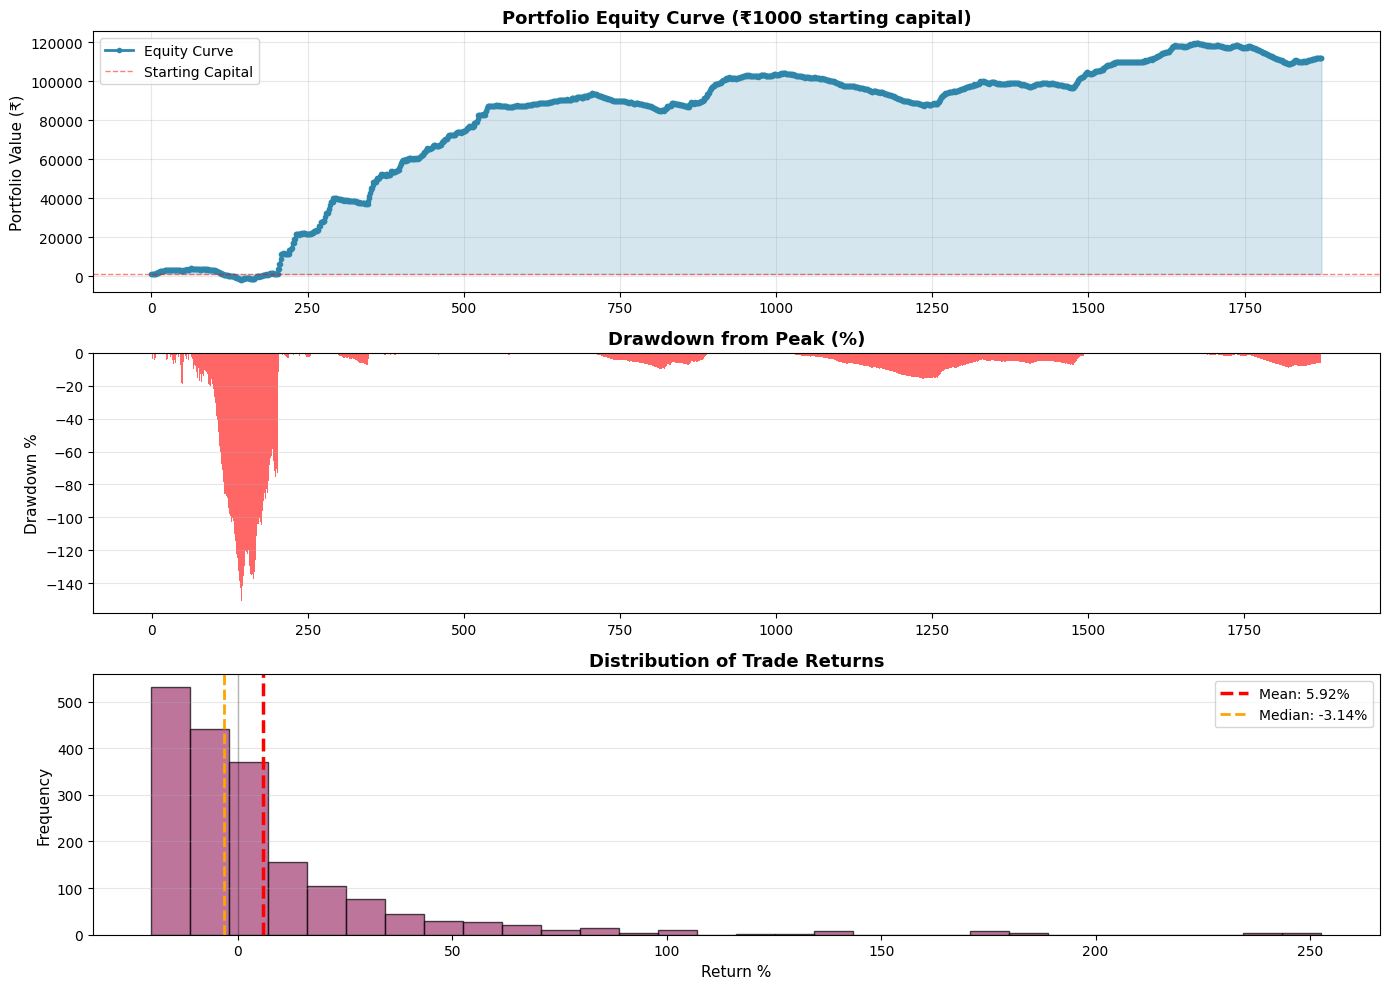

Portfolio equity curve, drawdown, and return distribution plotted.


In [40]:
# ============================================================================
# STEP 6: VISUALIZE RESULTS
# ============================================================================

if not results.empty:
    # Sort by entry date and calculate cumulative equity
    results_sorted = results.sort_values('entry_date').reset_index(drop=True)
    
    # Recalculate equity curve for visualization
    starting_capital = 1000.0
    results_sorted['dollars_pnl'] = starting_capital * results_sorted['net_return']
    results_sorted['cumulative_pnl'] = results_sorted['dollars_pnl'].cumsum()
    results_sorted['equity_curve'] = starting_capital + results_sorted['cumulative_pnl']
    
    # Calculate drawdown for visualization
    cummax = results_sorted['equity_curve'].expanding().max()
    drawdown_pct = ((results_sorted['equity_curve'] - cummax) / cummax) * 100
    
    # Create 3-panel visualization
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(14, 10))
    
    # Panel 1: Equity Curve
    ax1.plot(range(len(results_sorted)), results_sorted['equity_curve'], 
             marker='o', linestyle='-', linewidth=2, markersize=3, color='#2E86AB', label='Equity Curve')
    ax1.axhline(y=starting_capital, color='red', linestyle='--', alpha=0.5, linewidth=1, label='Starting Capital')
    ax1.fill_between(range(len(results_sorted)), starting_capital, results_sorted['equity_curve'], 
                     alpha=0.2, color='#2E86AB')
    ax1.set_title('Portfolio Equity Curve (₹1000 starting capital)', fontsize=13, fontweight='bold')
    ax1.set_ylabel('Portfolio Value (₹)', fontsize=11)
    ax1.grid(True, alpha=0.3)
    ax1.legend(loc='upper left')
    
    # Panel 2: Drawdown
    colors = ['red' if x < 0 else 'green' for x in drawdown_pct]
    ax2.bar(range(len(drawdown_pct)), drawdown_pct, color=colors, alpha=0.6, width=1)
    ax2.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
    ax2.set_title('Drawdown from Peak (%)', fontsize=13, fontweight='bold')
    ax2.set_ylabel('Drawdown %', fontsize=11)
    ax2.grid(True, alpha=0.3, axis='y')
    
    # Panel 3: Return Distribution
    returns_pct = results_sorted['net_return'] * 100
    ax3.hist(returns_pct, bins=30, color='#A23B72', alpha=0.7, edgecolor='black')
    ax3.axvline(returns_pct.mean(), color='red', linestyle='--', linewidth=2.5, label=f'Mean: {returns_pct.mean():.2f}%')
    ax3.axvline(returns_pct.median(), color='orange', linestyle='--', linewidth=2, label=f'Median: {returns_pct.median():.2f}%')
    ax3.axvline(0, color='black', linestyle='-', linewidth=1, alpha=0.3)
    ax3.set_title('Distribution of Trade Returns', fontsize=13, fontweight='bold')
    ax3.set_xlabel('Return %', fontsize=11)
    ax3.set_ylabel('Frequency', fontsize=11)
    ax3.legend()
    ax3.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()
    
    print('Portfolio equity curve, drawdown, and return distribution plotted.')

In [41]:
# ============================================================================
# STEP 7: EXPORT RESULTS
# ============================================================================

if not results.empty:
    # Save detailed trade log
    output_file = 'nse_monthly_breakout_trades.csv'
    results_export = results.copy()
    results_export['entry_date'] = results_export['entry_date'].dt.date
    results_export['exit_date'] = results_export['exit_date'].dt.date
    results_export['gross_return'] = results_export['gross_return'] * 100
    results_export['net_return'] = results_export['net_return'] * 100
    results_export = results_export.round(2)
    results_export.to_csv(output_file, index=False)
    print(f'✅ Trade log exported: {output_file}')
    print(f'   Total rows: {len(results_export)}')

✅ Trade log exported: nse_monthly_breakout_trades.csv
   Total rows: 1874
